# Convolutional GPROF rain rate retrieval

In this notebook we will use a convolutional neural network for predicting precipitation from multiple GMI pixels simultaneously. To keep the example simple, we will only work with a small amount of data and train a model to overfit on this small amount of data. Although such a  model cannot be expected to work well in practice, it will suffice to demonstrate how these type of models can be trained using the quantnn package.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from quantnn.plotting import set_style
set_style()

## The Data

In [2]:
from quantnn.examples.gprof_conv import download_data
download_data()

In [3]:
data = np.load("data/gprof_conv.npz")
x_train = np.transpose(data["x_train"], [0, 2, 3, 1])
y_train = data["y_train"]
x_val = np.transpose(data["x_val"], [0, 2, 3, 1])
y_val = data["y_val"]

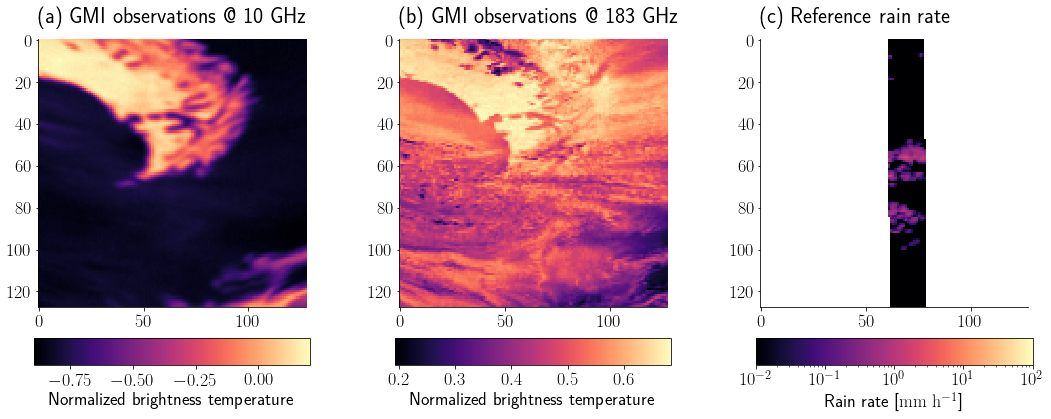

In [4]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(15, 6))
gs =  GridSpec(2, 3, figure=f, height_ratios=[1.0, 0.1])
index = np.random.randint(x_train.shape[0])

precip_norm = LogNorm(1e-2, 1e2)

ax = plt.subplot(gs[0, 0])
m = ax.imshow(x_train[index, :, :, 0])
ax.grid(False)
ax.set_title("(a) GMI observations @ 10 GHz", loc="left")
ax = plt.subplot(gs[1, 0])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

ax = plt.subplot(gs[0, 1])
m = ax.imshow(x_train[index, :, :, 10])
ax.grid(False)
ax.set_title("(b) GMI observations @ 183 GHz", loc="left")
ax = plt.subplot(gs[1, 1])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

ax = plt.subplot(gs[0, 2])
m = ax.imshow(y_train[index, :, :], norm=precip_norm)
ax.grid(False)
ax.set_title("(c) Reference rain rate", loc="left")
ax = plt.subplot(gs[1, 2])
plt.colorbar(m, cax=ax, orientation="horizontal", label=r"Rain rate [$\unit{mm\ h^{-1}}$]")

plt.tight_layout()

## Training a baseline model

In [34]:
from quantnn.models.keras import FullyConnected
from quantnn.qrnn import QRNN

quantiles = np.linspace(0.01, 0.99, 99)

simple_model = FullyConnected(
    n_inputs=13,
    n_outputs=quantiles.size,
    n_layers=3,
    width=128,
    activation="relu",
    convolutional=True
)
qrnn_fc = QRNN(quantiles=quantiles, model=simple_model)

In [19]:
simple_model.summary()

Model: "fully_connected_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_14 (Conv2D)              (None, None, None, 1 1792        conv2d_14_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, None, None, 1 512         conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_4 (Activation)       (None, None, None, 1 0           batch_normalization_10[0][0]     
                                                                 batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 1 16512       activation_4[0][0

In [22]:
from quantnn.models.keras import BatchedDataset
from keras.optimizers import SGD

training_data = BatchedDataset((x_train, y_train), 1)
optimizer = SGD(lr=0.1, momentum=0.9)
qrnn_fc.train(training_data=training_data,
              n_epochs=5,
              optimizer=optimizer,
              mask=-1)
optimizer = SGD(lr=0.01, momentum=0.9)
qrnn_fc.train(training_data=training_data,
              n_epochs=5,
              optimizer=optimizer,
              mask=-1)
optimizer = SGD(lr=0.001, momentum=0.0)
qrnn_fc.train(training_data=training_data,
              n_epochs=5,
              optimizer=optimizer,
              mask=-1)

Epoch  1 /  5: train. loss = 0.0866, lr. = 0.1000, time = 11.633724 s
Epoch  2 /  5: train. loss = 0.0497, lr. = 0.1000, time = 11.565032 s
Epoch  3 /  5: train. loss = 0.0485, lr. = 0.1000, time = 11.559901 s
Epoch  4 /  5: train. loss = 0.0456, lr. = 0.1000, time = 11.582606 s
Epoch  5 /  5: train. loss = 0.0424, lr. = 0.1000, time = 11.589288 s


Epoch  1 /  5: train. loss = 0.0391, lr. = 0.0100, time = 11.607945 s
Epoch  2 /  5: train. loss = 0.0389, lr. = 0.0100, time = 11.610813 s
Epoch  3 /  5: train. loss = 0.0425, lr. = 0.0100, time = 11.599108 s
Epoch  4 /  5: train. loss = 0.0425, lr. = 0.0100, time = 11.620147 s
Epoch  5 /  5: train. loss = 0.0431, lr. = 0.0100, time = 11.637173 s


Epoch  1 /  5: train. loss = 0.0392, lr. = 0.0010, time = 11.612811 s
Epoch  2 /  5: train. loss = 0.0379, lr. = 0.0010, time = 11.603013 s
Epoch  3 /  5: train. loss = 0.0373, lr. = 0.0010, time = 11.607124 s
Epoch  4 /  5: train. loss = 0.0380, lr. = 0.0010, time = 11.60293 s
Epoch  5 /  5: train. loss = 0.0456, lr. = 0.0010, time = 11.61491 s


## Training a U-Net QRNN

In [28]:
from quantnn.models.keras.unet import UNet
from quantnn.qrnn import QRNN
model = UNet(13, quantiles.size)
qrnn_unet = QRNN(quantiles=quantiles, model=model)

In [29]:
model.build((None, 128, 128, 13))
model.summary()

Model: "u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 128, 128, 64)      44992     
_________________________________________________________________
downsampling_block_4 (Downsa (None, 64, 64, 128)       222464    
_________________________________________________________________
downsampling_block_5 (Downsa (None, 32, 32, 256)       887296    
_________________________________________________________________
downsampling_block_6 (Downsa (None, 16, 16, 512)       3544064   
_________________________________________________________________
downsampling_block_7 (Downsa (None, 8, 8, 1024)        14166016  
_________________________________________________________________
upsampling_block_4 (Upsampli multiple                  7607808   
_________________________________________________________________
upsampling_block_5 (Upsampli multiple                  1903

In [30]:
optimizer = SGD(lr=0.1, momentum=0.9)
qrnn_unet.train(training_data=training_data,
                n_epochs=5,
                optimizer=optimizer,
                mask=-1)
optimizer = SGD(lr=0.01, momentum=0.9)
qrnn_unet.train(training_data=training_data,
                n_epochs=5,
                optimizer=optimizer,
                mask=-1)
optimizer = SGD(lr=0.001, momentum=0.0)
qrnn_unet.train(training_data=training_data,
                n_epochs=5,
                optimizer=optimizer,
                mask=-1)

Epoch  1 /  5: train. loss = 0.0645, lr. = 0.1000, time = 113.468573 s
Epoch  2 /  5: train. loss = 0.0507, lr. = 0.1000, time = 113.932696 s
Epoch  3 /  5: train. loss = 0.0468, lr. = 0.1000, time = 113.992829 s
Epoch  4 /  5: train. loss = 0.0473, lr. = 0.1000, time = 114.226912 s
Epoch  5 /  5: train. loss = 0.0417, lr. = 0.1000, time = 114.383097 s


KeyboardInterrupt: 

## Evaluating the models

To evaluate the two models, we will compare the predicted mean precipitation values to the reference value, where this data is available.

In [42]:
import tensorflow as tf
with tf.device("cpu"):
    y_pred_simple = qrnn_fc.posterior_mean(x=x_val)
    y_pred_unet = qrnn_unet.posterior_mean(x=x_val)

In [71]:
bins = np.logspace(-2, 2, 41)
freqs_simple, _, _ = np.histogram2d(y_val[indices], y_pred_simple[indices], bins=bins)
freqs_unet, _, _ = np.histogram2d(y_val[indices], y_pred_unet[indices], bins=bins)

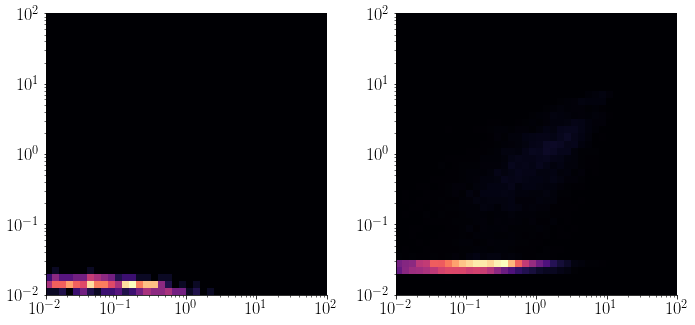

In [72]:
indices = y_val >= 0.0


f, axs = plt.subplots(1, 2, figsize=(10, 5))


ax = axs[0]
ax.pcolormesh(bins, bins, freqs_simple.T)
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect(1.0)

ax = axs[1]
ax.pcolormesh(bins, bins, freqs_unet.T)
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_aspect(1.0)

plt.tight_layout()
